# Title

Deep Fake Image and Video Detection using CNN's and RNN's

# Problem Statement

DeepFake is composed from Deep Learning and Fake and means taking one person from an image or video and replacing with someone else likeness using technology such as Deep Artificial Neural Networks. Large companies like Google invest very much in fighting the DeepFake, this including release of large datasets to help training models to counter this threat.The phenomen invades rapidly the film industry and threatens to compromise news agencies. Large digital companies, including content providers and social platforms are in the frontrun of fighting Deep Fakes. GANs that generate DeepFakes becomes better every day and, of course, if you include in a new GAN model all the information we collected until now how to combat various existent models, we create a model that cannot be beatten by the existing ones.

First we will work on detecting faces that were forged and we will work on developing a model to detect videos.

# DeepFake Image detection

## About the Dataset

This dataset contains faces extracted from deepfake-detection-challenge. All images were of size 224x224. 

Due to memory issue we will only use a sample of the entire dataset for prediction.

## Importing Required libraries

In [17]:
!pip install -U --upgrade tensorflow
!pip install visualkeras


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [18]:
import sys
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt
import visualkeras

In [19]:
tf.test.gpu_device_name()
# tf.test.is_gpu_available()

2023-11-08 11:45:02.909960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-08 11:45:02.910004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'/device:GPU:0'

In [20]:
tf.__version__

'2.14.0'

In [21]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [22]:
import os

def get_data():
    return pd.read_csv('input/deepfake-faces/metadata.csv')

In [23]:
meta=get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [24]:
meta.shape

(95634, 5)

In [25]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

In [26]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

fake_df = fake_df.sample(sample_size, random_state=42)
# real_df = real_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

As mentioned instead of using 95k images we will only use 16000 images.

In [27]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [28]:
Train_set.shape,Val_set.shape,Test_set.shape

((13603, 5), (5831, 5), (4859, 5))

In [29]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

The original image dataset were biased with more fake images than real since we are taking a sample of it its better to take equal proportion of real and fake images.

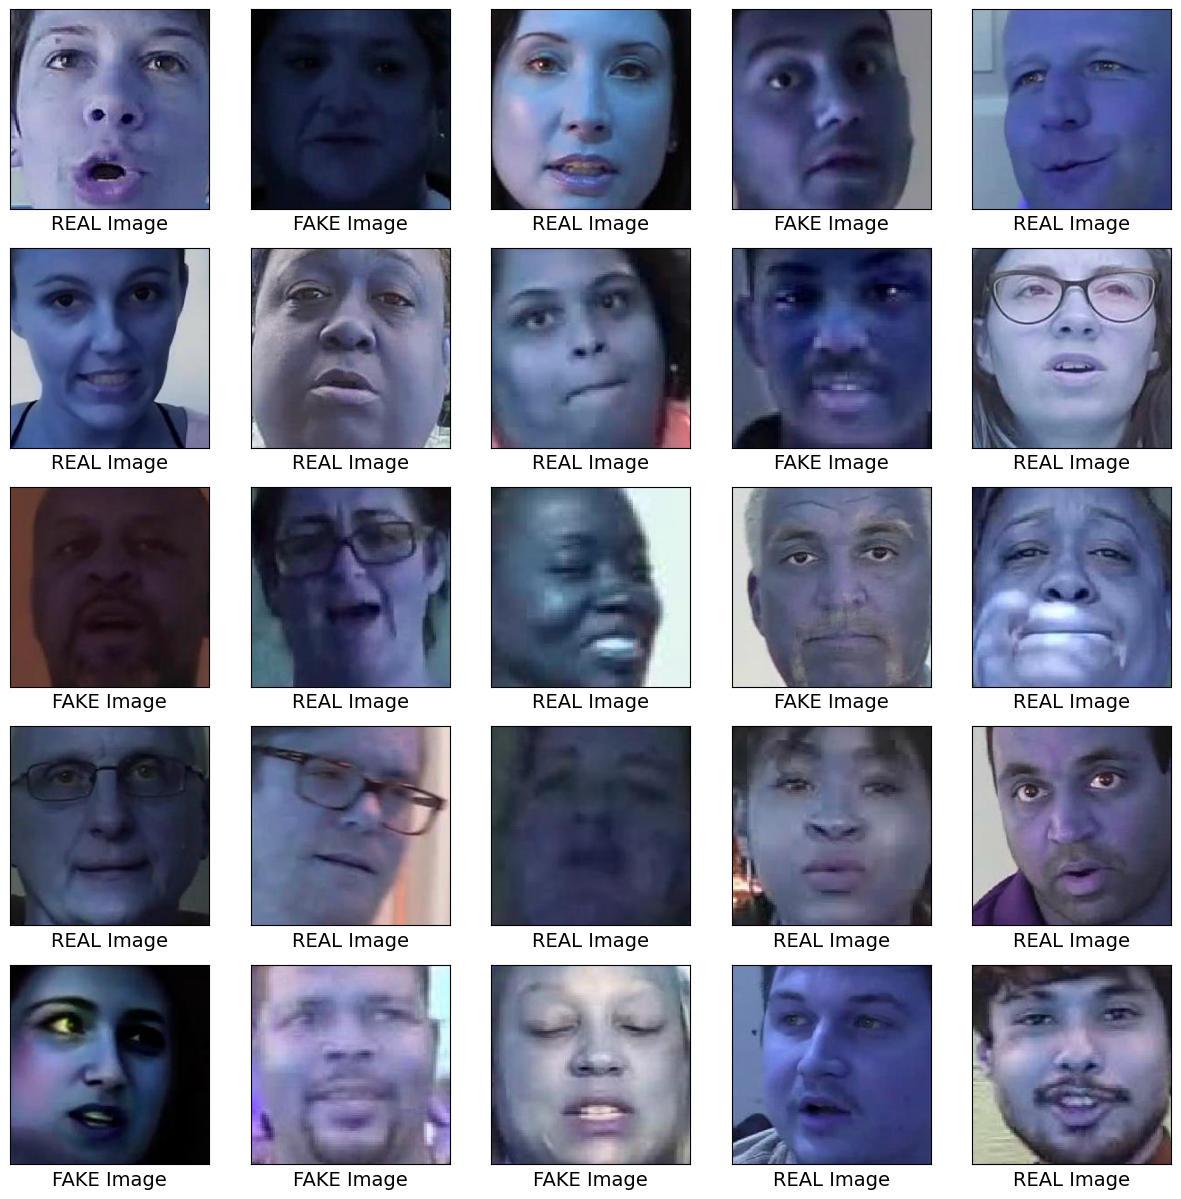

In [30]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

## Modelling

Before jumping to use pretrained model lets develop some base line model to test how our pretrained model outperforms.

### Custom CNN Architecture

In [31]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images).astype('float16')/255.,np.array(labels)

In [ ]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [ ]:
from functools import partial
from tensorflow.keras.models import Model

tf.random.set_seed(42) 

class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
    self.DefaultConv2DTr = partial(tf.keras.layers.Conv2DTranspose, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
    self.encoder = tf.keras.Sequential([
        self.DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
        tf.keras.layers.MaxPool2D(),
        self.DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        self.DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        self.DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        self.DefaultConv2D(filters=64),
        self.DefaultConv2D(filters=64),
        tf.keras.layers.Flatten(),
    ])
    
    self.decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(units=12544, activation="relu",
                              kernel_initializer="he_normal", input_shape=[400]),
        tf.keras.layers.Reshape((14, 14, 64)),
        self.DefaultConv2DTr(filters=64),
        self.DefaultConv2DTr(filters=64),
        self.DefaultConv2DTr(filters=128),
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        self.DefaultConv2DTr(filters=128),
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        self.DefaultConv2DTr(filters=128),
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        self.DefaultConv2DTr(filters=64),
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        self.DefaultConv2DTr(filters=3, kernel_size=7, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
autoencoder = AutoEncoder()
autoencoder.encoder.summary()
autoencoder.decoder.summary()

In [ ]:
visualkeras.layered_view(autoencoder.encoder, legend=True, draw_volume=False)

In [ ]:
visualkeras.layered_view(autoencoder.decoder, legend=True, draw_volume=False)

In [ ]:
from tensorflow.keras import losses
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics='accuracy')

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=3, batch_size=4,
                    validation_data=(X_val, X_val))

In [ ]:
# !mkdir -p saved_model
autoencoder.save_weights('saved_model/ae_weights_win_v2')
# autoencoder.save('saved_model/ae_model_win')

In [ ]:
autoencoder.load_weights('saved_model/ae_weights_win_v2')

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
X_val = X_val.astype('float32')
encoded_imgs = autoencoder.encoder(X_val[:11]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(X_val[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    # plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False) 
plt.show()

In [ ]:
encoded_train = autoencoder.encoder(X_train[:100]).numpy()
# encoded_val = autoencoder.encoder(X_val).numpy()
# # encoded_test = autoencoder.encoder(X_test).numpy()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
logisticRegr = LogisticRegression()
logisticRegr.fit(encoded_train, y_train[:300])
randf_clf = RandomForestClassifier()
randf_clf.fit(encoded_train, y_train[:300])
svm_clf = SVC()
svm_clf.fit(encoded_train, y_train[:300])

In [ ]:
score1 = logisticRegr.score(encoded_val, y_val[:100])
score2 = randf_clf.score(encoded_val, y_val[:100])
score3 = svm_clf.score(encoded_val, y_val[:100])
print(score1, score2, score3)

A baseline score of 50.06% is good to go let's finetune some pretrained model

# Pretrained Models for Transfer Learning

Here i used Xception model for fine-tuning feel free to try the performance of other pretrained models.

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this. We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [24]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

NameError: name 'asdfhak' is not defined

In [ ]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all with values ranging from -1 to 1:

In [ ]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

Try running the following cell multiple times to see different random data augmentations:

In [ ]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

Now let's load the pretrained model, without its top layers, and replace them with our own task

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Let's train the model for a few epochs, while keeping the base model weights fixed:

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

In [ ]:
model.evaluate(test_set)

Now with the finetuning the top layers of xception model the model performance jumps to 63.8% 

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate:

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model.evaluate(test_set)

The model accuracy finally reaches to 81.9%

In [ ]:
model.save('xception_deepfake_image.h5')

# Add Explainability to the model

Lets try to interpret the trained model on how it finds a image FAKE

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [ ]:
plt.figure(figsize=(12, 12))

for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow((x[index] + 1) / 2)  # rescale to 0–1 for imshow()
    if(y[index]==1):
        classt='FAKE'
    else:
        classt='REAL'
    plt.title(f"Class: {classt}")
    plt.axis("off")

plt.show()

In [ ]:
test_data=x[2,:,:,:]
test_data.shape

In [ ]:
explanation = explainer.explain_instance(test_data.astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

# Deep Fake Video Classification

## About the dataset

Files

* train_sample_videos.zip - a ZIP file containing a sample set of training videos and a metadata.json with labels. the full set of training videos is available through the links provided above.
* sample_submission.csv - a sample submission file in the correct format.
* test_videos.zip - a zip file containing a small set of videos to be used as a public validation set. To understand the datasets available for this competition, review the Getting Started information.

Metadata Columns

* filename - the filename of the video
* label - whether the video is REAL or FAKE
* original - in the case that a train set video is FAKE, the original video is listed here
* split - this is always equal to "train".

## Importing required libraries

In [ ]:
!pip install -U --upgrade tensorflow

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
#from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Data Visualisation

In [ ]:
DATA_FOLDER = '../input/deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

In [ ]:
train_sample_metadata = pd.read_json('../input/deepfake-detection-challenge/train_sample_videos/metadata.json').T
train_sample_metadata.head()

In [ ]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

In [ ]:
train_sample_metadata.shape

Let's visualize now the data.

We select first a list of fake videos.

### Few fake videos

In [ ]:
fake_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].sample(3).index)
fake_train_sample_video

In [ ]:
def display_image_from_video(video_path):
    '''
    input: video_path - path for video
    process:
    1. perform a video capture from the video
    2. read the image
    3. display the image
    '''
    capture_image = cv2.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

In [ ]:
for video_file in fake_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

Let's try now the same for few of the images that are real.

### Few Real Videos

In [ ]:
real_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='REAL'].sample(3).index)
real_train_sample_video

In [ ]:
for video_file in real_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

### Videos with same original

Let's look now to set of samples with the same original.

In [ ]:
train_sample_metadata['original'].value_counts()[0:5]

We pick one of the originals with largest number of samples.

We also modify our visualization function to work with multiple images.

In [ ]:
def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list[0:6]):
        video_path = os.path.join(DATA_FOLDER, video_folder,video_file)
        capture_image = cv2.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')


In [ ]:
same_original_fake_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.original=='atvmxvwyns.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

### Test video files

Let's also look to few of the test data files.

In [ ]:
test_videos = pd.DataFrame(list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER))), columns=['video'])

In [ ]:
test_videos.head()

Let's visualize now one of the videos.

In [ ]:
display_image_from_video(os.path.join(DATA_FOLDER, TEST_FOLDER, test_videos.iloc[2].video))

### Play video files

Let's look to few fake videos.

In [ ]:
fake_videos = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].index)

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file, subset=TRAIN_SAMPLE_FOLDER):
    '''
    Display video
    param: video_file - the name of the video file to display
    param: subset - the folder where the video file is located (can be TRAIN_SAMPLE_FOLDER or TEST_Folder)
    '''
    video_url = open(os.path.join(DATA_FOLDER, subset,video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" % data_url)

play_video(fake_videos[10])

From visual inspection of these fakes videos, in some cases is very easy to spot the anomalies created when engineering the deep fake, in some cases is more difficult.

## Modelling

### A CNN-RNN Architecture

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

 In this example we will do the following:

* Capture the frames of a video.
* Extract frames from the videos until a maximum frame count is reached.
* In the case, where a video's frame count is lesser than the maximum frame count we will pad the video with zeros.

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

We can use a pre-trained network to extract meaningful features from the extracted frames. The Keras Applications module provides a number of state-of-the-art models pre-trained on the ImageNet-1k dataset. We will be using the InceptionV3 model for this purpose.

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

Finally, we can put all the pieces together to create our data processing utility.

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = list(df.index)
    labels = df["label"].values
    labels = np.array(labels=='FAKE').astype(np.int)

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

Since we don't have test labels we split the training data to find its performance in unseen data

In [ ]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(train_sample_metadata,test_size=0.1,random_state=42,stratify=train_sample_metadata['label'])

print(Train_set.shape, Test_set.shape )

In [ ]:
train_data, train_labels = prepare_all_videos(Train_set, "train")
test_data, test_labels = prepare_all_videos(Test_set, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like GRU.

In [ ]:
frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
x = keras.layers.GRU(16, return_sequences=True)(
    frame_features_input, mask=mask_input
)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model([frame_features_input, mask_input], output)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('./', save_weights_only=True, save_best_only=True)
history = model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_data=([test_data[0], test_data[1]],test_labels),
        callbacks=[checkpoint],
        epochs=EPOCHS,
        batch_size=8
    )

### Inference

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(os.path.join(DATA_FOLDER, TEST_FOLDER,path))
    frame_features, frame_mask = prepare_single_video(frames)
    return model.predict([frame_features, frame_mask])[0]
    
# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_videos["video"].values.tolist())
print(f"Test video path: {test_video}")

if(sequence_prediction(test_video)>=0.5):
    print(f'The predicted class of the video is FAKE')
else:
    print(f'The predicted class of the video is REAL')

play_video(test_video,TEST_FOLDER)

Here we used simple RNN model feel free to try some complex Attention based and Transformer based models

# Conclusion

The deep fake image classifier and deep fake video classifier model gave a generalisation error of around 80%

# Reference and Thanks to 

https://keras.io/examples/vision/video_classification/

https://www.kaggle.com/code/gpreda/deepfake-starter-kit

https://www.kaggle.com/code/robikscube/kaggle-deepfake-detection-introduction

https://www.kaggle.com/code/humananalog/binary-image-classifier-training-demo

https://www.kaggle.com/datasets/dagnelies/deepfake-faces

**Please UPVOTE if you found the notebook useful**